In [27]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from torch.nn.functional import softmax
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig
from netrep.metrics import LinearMetric, GaussianStochasticMetric, EnergyStochasticMetric

model_1m = AutoModelForCausalLM.from_pretrained('/Users/joshstallings/Desktop/LipshutzLab/TinyStories-1M')
model_3m = AutoModelForCausalLM.from_pretrained('/Users/joshstallings/Desktop/LipshutzLab/TinyStories-3M')

# model_1m = AutoModelForCausalLM.from_pretrained("state-spaces/mamba2-130m", dtype="auto") #TODO: figure out issues with this
# Load model_1m directly
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-125M")
model_1m.eval()
model_3m.eval()

# Define the hook function
PROMPT = "Once upon a time there was"
TEMPERATURE = 3

NUM_EXPERIMENTS = 800
NUM_TOKENS = 20


In [28]:
print(model_1m.transformer.h)
print(model_3m.transformer.h)

ModuleList(
  (0-7): 8 x GPTNeoBlock(
    (ln_1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (attn): GPTNeoAttention(
      (attention): GPTNeoSelfAttention(
        (attn_dropout): Dropout(p=0.0, inplace=False)
        (resid_dropout): Dropout(p=0.0, inplace=False)
        (k_proj): Linear(in_features=64, out_features=64, bias=False)
        (v_proj): Linear(in_features=64, out_features=64, bias=False)
        (q_proj): Linear(in_features=64, out_features=64, bias=False)
        (out_proj): Linear(in_features=64, out_features=64, bias=True)
      )
    )
    (ln_2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (mlp): GPTNeoMLP(
      (c_fc): Linear(in_features=64, out_features=256, bias=True)
      (c_proj): Linear(in_features=256, out_features=64, bias=True)
      (act): NewGELUActivation()
      (dropout): Dropout(p=0.0, inplace=False)
    )
  )
)
ModuleList(
  (0-7): 8 x GPTNeoBlock(
    (ln_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (at

In [ ]:


# My custom generate function. 
def generate(model, model_name, layer_to_record = -1, activation_responses = [], token_responses = []):
    # Custom Generation loop. 

    def get_activation(name):
        def hook(model, input, output):
            # We save the output of the layer
            saved_activations[name].append(output)
        return hook
    
    if layer_to_record == None:
        for layer in model.transformer.h:
            layer.register_forward_hook(get_activation(model_name))
    else:
        model.transformer.h[layer_to_record].register_forward_hook(get_activation(model_name))

    for i in range(NUM_EXPERIMENTS):
        # Tokenize the input. 
        input_ids = tokenizer(PROMPT, return_tensors="pt").input_ids
        current_ids = input_ids

        saved_activations = {}
        saved_activations[model_name] = []

        
        for _ in range(NUM_TOKENS): # Generate N new tokens
            # Model forward pass. The hook will be triggered here.
            with torch.no_grad():
                outputs = model(current_ids)
            
            # Get the logits for the next token
            # Logits are values before they are passed to the activation function.
            logits = outputs.logits
            next_token_logits = logits[:, -1, :]
            scaled_logits = next_token_logits

            if TEMPERATURE > 0:
                scaled_logits = next_token_logits / TEMPERATURE


            top_k = 50  # Keep only the top 50 most likely tokens
            indices_to_remove = scaled_logits < torch.topk(scaled_logits, top_k)[0][..., -1, None]
            scaled_logits[indices_to_remove] = -float('Inf')
            
            # 3. Apply Top-P (nucleus) sampling
            top_p = 0.95  # Keep tokens that add up to 95% probability
            sorted_logits, sorted_indices = torch.sort(scaled_logits, descending=True)
            cumulative_probs = torch.cumsum(softmax(sorted_logits, dim=-1), dim=-1)
            
            # Find the tokens that fall within the cumulative probability
            sorted_indices_to_remove = cumulative_probs > top_p
            sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
            sorted_indices_to_remove[..., 0] = 0
            
            indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)
            scaled_logits[indices_to_remove] = -float('Inf')
            next_token_id = torch.multinomial(softmax(scaled_logits, dim=-1), num_samples=1)

            # Append the new token to the sequence
            current_ids = torch.cat([current_ids, next_token_id], dim=-1)

            # TODO: Test & ASK about this. Do we want this behavior?
            if(current_ids[0] == tokenizer.eos_token_id):
                break

        activation_responses.append(saved_activations[model_name]) # take the very last activation
        token_responses.append(current_ids[0]) 
            

    return activation_responses, token_responses


In [20]:
activation_responses_1m, token_responses_1m = generate(model_1m, "1m")
activation_responses_3m, token_responses_3m = generate(model_3m, "3m")


In [21]:
for i in range(NUM_EXPERIMENTS):
    token_response_1m = token_responses_1m[i]
    token_response_3m = token_responses_3m[i]

    print(f"1M: {tokenizer.decode(token_response_1m)}")
    print(f"3M: {tokenizer.decode(token_response_3m)}")

1M: Once upon a time there was a cute animal at woods near its cozy bed. Its eyes lit brighter because that this mist smelled wonderfulest scent they sang. In last steps'Welcome up. When someone went underground here and in full
3M: Once upon a time there was a cute animal at woods near its cozy bed. Its eyes lit brighter because that this mist smelled wonderfulest scent they sang. In last steps'Welcome up. When someone went underground here and in full
1M: Once upon a time there was an adventure. As every time made spring of flowers and the clouds in the world around people there. Whenever the flowers became gloomy like even scary to reach it but instead is soon again tomorrow made their house
3M: Once upon a time there was an adventure. As every time made spring of flowers and the clouds in the world around people there. Whenever the flowers became gloomy like even scary to reach it but instead is soon again tomorrow made their house
1M: Once upon a time there was a young boy called 

In [22]:
tensors_1m = []
tensors_3m = []
tensors = []

for i in range(NUM_EXPERIMENTS):
    response_1m = activation_responses_1m[i]
    response_3m =  activation_responses_3m[i]

    try:
        tensor_1m = response_1m[0][0].numpy()
    except:
        tensor_1m = response_1m[0][0]
    try:
        tensor_3m = response_3m[0][0].numpy()
    except:
        tensor_3m = response_3m[0][0]

    tensors_1m.append(tensor_1m)
    tensors_3m.append(tensor_3m)

    tensors.append(tensor_1m)
    tensors.append(tensor_3m)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

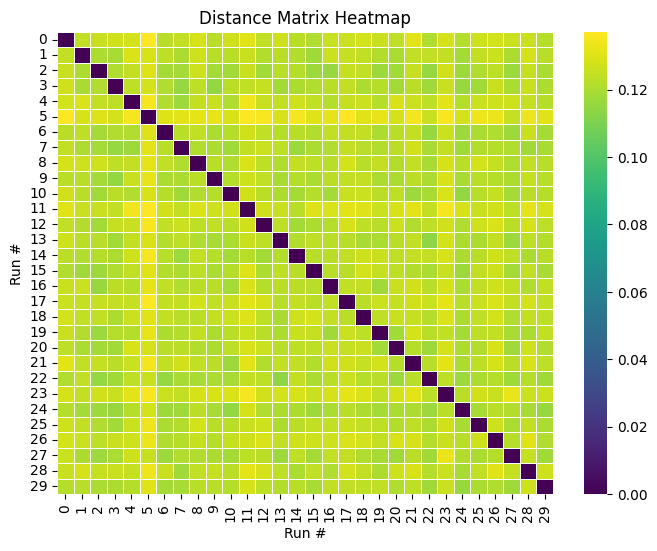

In [25]:
# alpha = 0  => linearly invariant, like CCA
# alpha = 1 => rotationally invariant, only rotational alignments. 
metric = LinearMetric(alpha=0.5)
dist_matrix_1, _ = metric.pairwise_distances(tensors_3m[:30], verbose=False)
# dist_matrix_2, _  = metric.pairwise_distances(tensor_2s)  # these aren't 2d arrays need to figure that out

plt.figure(figsize=(8, 6)) # Adjust figure size as needed
sns.heatmap(dist_matrix_1, cmap='viridis', annot=False, fmt=".2f", linewidths=.5)

plt.title('Distance Matrix Heatmap')
plt.xlabel('Run #')
plt.ylabel('Run #')
plt.show()


In [150]:
metric = EnergyStochasticMetric()
dist_matrix_1, _ = metric.pairwise_distances(tensor_1s, verbose=False)
# dist_matrix_2, _  = metric.pairwise_distances(tensor_2s)  # these aren't 2d arrays need to figure that out

plt.figure(figsize=(8, 6)) # Adjust figure size as needed
sns.heatmap(dist_matrix_1, cmap='viridis', annot=False, fmt=".2f", linewidths=.5)

plt.title('Distance Matrix Heatmap')
plt.xlabel('Run #')
plt.ylabel('Run #')
plt.show()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

KeyboardInterrupt: 